In [1]:
# Install basic modules and make sure they are available with the latest pip version.
# Always updating PIP could be either good or bad, you just have to choose one base on the situation around.

# I use --quiet and --no-warn-script-location to hide the output of my directory paths
import sys
import os

!{sys.executable} -m pip install --upgrade pip matplotlib numpy tensorflow-macos tensorflow-metal scikit-learn --quiet --no-warn-script-location

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Model
import numpy as np
import os
from PIL import Image
import glob

# Define dataset path
dataset_path = os.path.join(os.getcwd().replace("investigation", "kaggledataset"), 'garbage_classification')

# Load all images and labels
image_data = []
labels = []
class_names = sorted(os.listdir(dataset_path))
print(f"Classes: {class_names}")

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in glob.glob(os.path.join(class_folder, "*.jpg")):
            try:
                # Open the image, resize, and normalize
                img = Image.open(img_file).convert("RGB").resize((256, 256))
                image_data.append(np.array(img) / 255.0)  # Normalize to 0-1 range
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

# Convert to NumPy arrays
image_data = np.array(image_data, dtype="float32")
labels = np.array(labels)

# One-hot encode the labels
labels_one_hot = to_categorical(labels, num_classes=len(class_names))

# Split data into 80/20 train/validation
train_data, test_data, train_labels, test_labels = train_test_split(
    image_data, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {test_data.shape}")
print(f"Validation labels shape: {test_labels.shape}")


Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Train data shape: (12412, 256, 256, 3)
Train labels shape: (12412, 12)
Validation data shape: (3103, 256, 256, 3)
Validation labels shape: (3103, 12)


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(class_names)  # Number of classes in the dataset

# Load the ResNet50 model with pretrained weights
base_model = EfficientNetB0(
    weights='imagenet',    # Use pretrained weights
    include_top=False,     # Exclude the fully connected top layers
    input_shape=(256, 256, 3)  # Input shape must match your data
)

# Freeze the base model layers (optional, for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for your dataset
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten with GlobalAveragePooling2D for better performance
x = Dense(512, activation=None, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

model.summary()

2024-12-12 09:04:08.731715: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-12-12 09:04:08.731775: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-12-12 09:04:08.731793: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-12-12 09:04:08.731816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-12 09:04:08.731831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,713,647 (17.98 MB)

 Trainable params: 663,052 (2.53 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

In [3]:
from tensorflow.keras.optimizers import RMSprop, Adam

# Compile the model
# optimizer = RMSprop(learning_rate=0.0001)
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,713,647 (17.98 MB)

 Trainable params: 3,189,916 (12.17 MB)

 Non-trainable params: 1,523,731 (5.81 MB)

In [6]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, restore_best_weights=True)

# Cyclical Learning Rate
def cyclic_lr(epoch):
    base_lr = 1e-5
    max_lr = 5e-4  # Lower max learning rate
    step_size = 10
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

lr_scheduler = LearningRateScheduler(cyclic_lr)

def augment_image(image, label):
    """Applies random augmentations to a single image."""
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random cropping (with resizing back to original size)
    image = tf.image.resize_with_crop_or_pad(image, target_height=300, target_width=300)  # Add padding
    image = tf.image.random_crop(image, size=[256, 256, 3])  # Crop back to the original size
    return image, label

# Convert NumPy arrays to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Apply augmentation to the training dataset
train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Batch and prefetch the validation dataset (no augmentation for validation)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 90s 202ms/step - accuracy: 0.0736 - loss: 4.1624 - val_accuracy: 0.0561 - val_loss: 3.6350 - learning_rate: 1.0000e-05
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 73s 187ms/step - accuracy: 0.0900 - loss: 3.9776 - val_accuracy: 0.2810 - val_loss: 3.3598 - learning_rate: 5.9000e-05
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 65s 167ms/step - accuracy: 0.1003 - loss: 3.8505 - val_accuracy: 0.1076 - val_loss: 3.3723 - learning_rate: 1.0800e-04
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 64s 163ms/step - accuracy: 0.0994 - loss: 3.6908 - val_accuracy: 0.2082 - val_loss: 3.2632 - learning_rate: 1.5700e-04
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 64s 163ms/step - accuracy: 0.1114 - loss: 3.5638 - val_accuracy: 0.2262 - val_loss: 3.2420 - learning_rate: 2.0600e-04
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - accuracy: 0.1292 - loss: 3.4290 - val_accuracy: 0.3458 - val_loss: 3.0946 - learning_rate: 2.5500e-04
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 64s 16

97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step
Overall Test Accuracy: 0.34


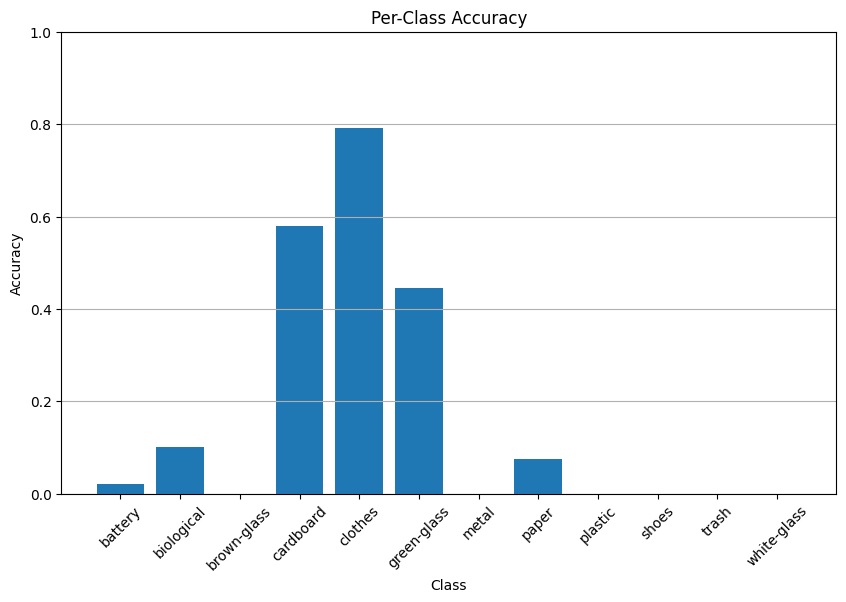

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the test data
predictions = model.predict(test_data)

# Convert predictions and true labels from one-hot to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate overall accuracy
overall_accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Overall Test Accuracy: {overall_accuracy:.2f}")

# Calculate per-class accuracy
num_classes = len(class_names)
class_accuracies = []
for class_index in range(num_classes):
    indices = np.where(true_classes == class_index)[0]
    class_correct = np.sum(predicted_classes[indices] == true_classes[indices])
    class_accuracy = class_correct / len(indices) if len(indices) > 0 else 0
    class_accuracies.append(class_accuracy)

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies)
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


In [7]:
model.save("saved_models/garbage_classification_model_rsnet_73_h5.h5")
model.save("saved_models/garbage_classification_model_rsnet_73_tf_keras.keras")

In [8]:
# Initialize an empty list to store misclassified images and details
misclassified_images = []

# Iterate through the test data to find misclassified samples
for i in range(len(test_data)):
    if predicted_classes[i] != true_classes[i]:
        misclassified_images.append({
            "expected": class_names[true_classes[i]],  # The correct label
            "predicted": class_names[predicted_classes[i]],  # The predicted label
            "image": test_data[i]  # The misclassified image
        })

# Check how many misclassifications were found
print(f"Total Misclassified Images: {len(misclassified_images)}")

Total Misclassified Images: 847


Index: 0, Expected: plastic, Predicted: paper
Index: 1, Expected: white-glass, Predicted: biological
Index: 2, Expected: shoes, Predicted: clothes
Index: 3, Expected: shoes, Predicted: brown-glass
Index: 4, Expected: white-glass, Predicted: plastic
Index: 5, Expected: clothes, Predicted: white-glass
Index: 6, Expected: battery, Predicted: biological
Index: 7, Expected: battery, Predicted: cardboard
Index: 8, Expected: cardboard, Predicted: paper
Index: 9, Expected: shoes, Predicted: battery
Index: 10, Expected: shoes, Predicted: white-glass
Index: 11, Expected: plastic, Predicted: trash
Index: 12, Expected: green-glass, Predicted: metal
Index: 13, Expected: paper, Predicted: plastic
Index: 14, Expected: green-glass, Predicted: brown-glass
Index: 15, Expected: plastic, Predicted: metal
Index: 16, Expected: cardboard, Predicted: plastic
Index: 17, Expected: cardboard, Predicted: clothes
Index: 18, Expected: shoes, Predicted: clothes
Index: 19, Expected: clothes, Predicted: white-glass
In

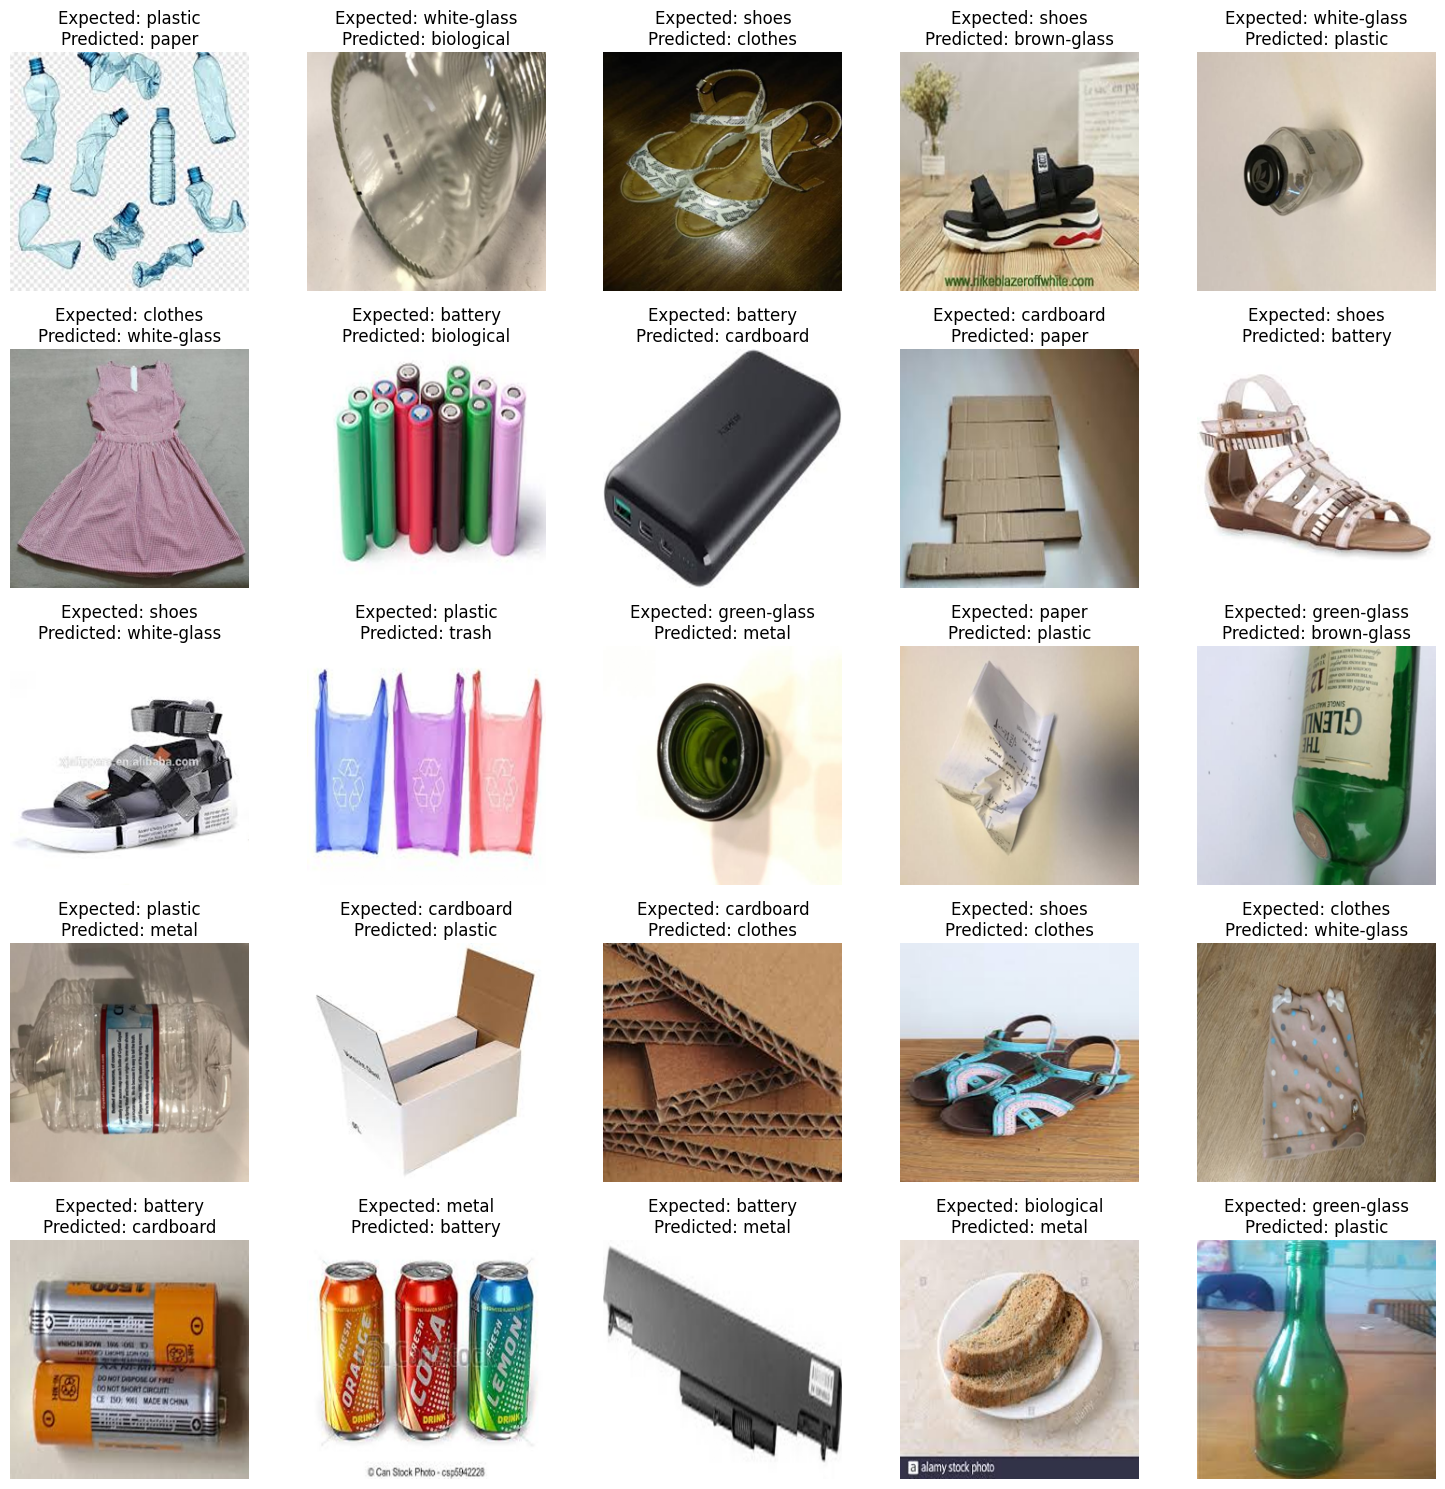

In [11]:
# Print all misclassified details
for idx, misclassified in enumerate(misclassified_images):
    print(f"Index: {idx}, Expected: {misclassified['expected']}, Predicted: {misclassified['predicted']}")

# Display up to 25 misclassified images (or all if fewer)
num_to_display = min(len(misclassified_images), 25)  # Adjust this to show more if needed
rows = int(np.ceil(num_to_display / 5))  # Calculate number of rows for a 5-column grid

plt.figure(figsize=(15, rows * 3))
for idx, misclassified in enumerate(misclassified_images[:num_to_display]):
    plt.subplot(rows, 5, idx + 1)
    plt.imshow(misclassified["image"])
    plt.title(f"Expected: {misclassified['expected']}\nPredicted: {misclassified['predicted']}")
    plt.axis("off")

plt.tight_layout()
plt.show()